<center> <h1> Tweet Sentiment Analysis </h1> </center>

<center> <img src="./Images/pexels-solen-feyissa-5744251.jpg" alt="Social Media" width="800"/> </center>
<center> Photo by Solen Feyissa - Courtesy of <a href="https://www.pexels.com/photo/internet-connection-technology-travel-5744251/"> Pexels </a> </center>

<center> <h4> Phase 4 Project by Ashley Eakland and Jose Harper </h4> </center>


#### Business Problem: Predicting Tweet sentiment based on Tweet content.

#### Stakeholder: Small tech company wanting to gain insight into consumer feelings on various company products. 

## Data Understanding
 * 9093 rows - 3 columns. Data comes from CrowdFlower via data.world. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, neither or "can't tell".



In [1]:
from collections import defaultdict
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import string
import re
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [4]:
import pandas as pd
df = pd.read_excel('Data/tweets.xlsx')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [5]:
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
df.emotion_in_tweet_is_directed_at.isna().sum()

5802

In [7]:
df.emotion_in_tweet_is_directed_at.fillna('Unknown', inplace=True)
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",Unknown,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",Unknown,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,Unknown,No emotion toward brand or product


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     9093 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [9]:
df[df['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,Unknown,No emotion toward brand or product


In [10]:
df.dropna(subset=['tweet_text'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     9092 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [11]:
df.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion'}, inplace=True)

In [12]:
df.rename(columns={'emotion_in_tweet_is_directed_at': 'Directed At'}, inplace=True)

In [13]:
df['Directed At'].value_counts()

Unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: Directed At, dtype: int64

In [14]:
df = df.drop(df[df['Emotion'] == "I can't tell"].index)

In [15]:
df_2 = df.drop(df[df['Emotion'] == "No emotion toward brand or product"].index)
df_2

,tweet_text,Directed At,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [16]:
#0 negative, 1 positive
le = LabelEncoder()
df_2['Emotion'] = le.fit_transform(df_2['Emotion'])

In [18]:
#Positive outweigh the negative 84% to 16%
df_2.Emotion.value_counts(normalize=True)

1    0.839346
0    0.160654
Name: Emotion, dtype: float64

In [19]:
df_2

,tweet_text,Directed At,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,1
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,1
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,0
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,1


In [32]:
X = df_2.tweet_text
y = df_2.Emotion

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_test

,tweet_text
685,New Post: iPad 2 Launches to Huge Lines at App...
6393,RT @mention NYT app for iPad: not &quot;here's...
7851,Steve Jobs doesn't position the iPhone as a de...
5813,RT @mention Google Circles will be toast if it...
2944,Thanks @mention for giving me new top cover fo...
...,...
2657,Got in the Google party not before being inter...
14,Great #sxsw ipad app from @madebymany: http://...
233,"If iPhone alarms botch the timechange, how man..."
3929,keep up with new on #Japan quake from iPhone a...


In [34]:
sw = stopwords.words('english')

In [35]:
# #NLP lecture modeling notebook
def get_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [41]:
# #NLP lecture modeling notebook - basic token pattern from cumulative NLP lab

def tweet_preparer(tweet, stopwords=sw):
    regex_token = RegexpTokenizer(r'([a-zA-Z]+)')
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return tweet

In [37]:
#method for modeling lecture notebook - countvectorizer Commenting out - don't use.
# X_train['tweet_text'] = [tweet_preparer(tweet, sw) for tweet in X_train['tweet_text']]

['giving', 'away', 'ipad', 'x', 'boxes', 'books', 'mention', 'sxsw', 'techenvy']
['setting', 'ipad', 'swift', 'upbeat', 'service', 'morning', 'sxsw', 'apple', 'pop', 'store']
['third', 'time', 'charm', 'gt', 'gt', 'gt', 'google', 'launch', 'new', 'social', 'network', 'sxsw', 'cnet', 'news', 'link']
['mention', 'used', 'think', 'started', 'making', 'great', 'apps', 'official', 'sxsw', 'app', 'ipad', 'blows', 'versions', 'site', 'away']
['hopefully', 'best', 'thing', 'comes', 'sxsw', 'fact', 'people', 'flew', 'austin', 'pick', 'ipad']
['among', 'things', 'missing', 'sxsw', 'google', 'aclu', 'dance', 'party']
['biggest', 'frustration', 'sxsw', 'far', 'one', 'looks', 'going', 'glued', 'iphone']
['expect', 'lots', 'buzz', 'ipad', 'sxsw', 'since', 'comes', 'tomorrow', 'support', 'flash', 'maybe', 'link', 'elonsxsw']
['queue', 'apple', 'pop', 'store', 'sxsw', 'still', 'long']
['way', 'call', 'ipad', 'count', 'sxsw', 'reasonable', 'think', 'one', 'every', 'people']
['apple', 'employee', 'psych

['mike', 'tyson', 'launched', 'iphone', 'game', 'mention', 'sxsw', 'link', 'tech', 'news', 'link']
['mention', 'looking', 'lot', 'better', 'iphone', 'good', 'see', 'occasional', 'tweet', 'sxsw']
['looking', 'forward', 'learning', 'ipad', 'design', 'sxsw']
['either', 'go', 'sxsw', 'wait', 'line', 'buy', 'tricked', 'ipad', 'mom', 'birthday', 'guess', 'austin']
['never', 'apparent', 'sxsw', 'nice', 'would', 'apple', 'made', 'stuff', 'w', 'removable', 'batteries', 'alwayshavingtoplugin', 'gsdm']
['well', 'cashmore', 'gave', 'new', 'ipad', 'crushing', 'non', 'endorsement', 'sxsw', 'checkins', 'ouch']
['sxsw', 'mention', 'league', 'extraordinary', 'h', 'ckers', 'presented', 'google', 'w', 'others', 'link']
['mention', 'iphone', 'cases', 'rad', 'ready', 'stop', 'tomorrow', 'get', 'sxsw', 'zazzlesxsw', 'sxswi', 'link']
['rt', 'mention', 'ipad', 'unboxing', 'outside', 'sxsw', 'apple', 'store', 'link']
['mention', 'twitter', 'iphone', 'app', 'days', 'heading', 'sxsw', 'want', 'tweet', 'lot', 'he

['yes', 'updated', 'iphone', 'app', 'song', 'info', 'mention', 'stream', 'others', 'also', 'live', 'video', 'streaming', 'sxsw', 'link']
['band', 'sxsw', 'want', 'share', 'track', 'audience', 'stage', 'use', 'frostwire', 'android', 'wi', 'fi', 'available']
['rt', 'mention', 'smartphone', 'breakdown', 'sxsw', 'unofficial', 'iphones', 'android', 'blackberry', 'symbian', 'windows']
['rt', 'mention', 'ipad', 'lounge', 'recharge', 'coffee', 'h', 'ipad', 'art', 'show', 'free', 'daily', 'sxsw', 'e', 'th', 'congress', 'austin', 'details', 'link']
['mention', 'know', 'premature', 'tweet', 'love', 'see', 'pics', 'apple', 'pop', 'store', 'sxsw']
['google', 'future', 'quot', 'power', 'quot', 'paired', 'augmented', 'reality', 'contextual', 'reality', 'pnid', 'sxsw']
['lol', 'rt', 'mention', 'bet', 'lot', 'nerds', 'sxsw', 'using', 'iphone', 'light', 'saber', 'app', 'barroom', 'brawls', 'instead', 'fists']
['never', 'seen', 'many', 'heads', 'turn', 'one', 'point', 'someone', 'apple', 'asks', 'questio

['great', 'see', 'u', 'rt', 'mention', 'austin', 'convention', 'center', 'today', 'w', 'mention', 'fam', 'showing', 'new', 'iphone', 'game', 'sxsw']
['really', 'liking', 'sxsw', 'iphone', 'app', 'thanks', 'making', 'event', 'app', 'appears', 'work', 'well']
['anyone', 'else', 'headed', 'austin', 'sxsw', 'popup', 'store', 'launch', 'apple', 'ipad', 'friday', 'gonna', 'miss', 'mention', 'year']
['wow', 'iphone', 'dropped', 'side', 'iron', 'cactus', 'balcony', 'screen', 'shatter', 'amazing', 'sxsw', 'fb']
['check', 'googletv', 'ipad', 'apps', 'connected', 'tv', 'experience', 'sxsw', 'link', 'sxsw', 'connectedtv', 'fascinating']
['nice', 'apple', 'made', 'lots', 'sells', 'sure', 'rt', 'mention', 'apple', 'popup', 'store', 'sxsw', 'link']
['ipad', 'goes', 'sale', 'first', 'day', 'sxsw', 'atx', 'tomorrow', 'apple', 'sending', 'lorry', 'load', 'austin', 'riots', 'may', 'ensue']
['sxsw', 'apple', 'schools', 'marketing', 'experts', 'link', 'via', 'mention', 'sxsw', 'apple']
['rt', 'mention', 'w

['one', 'thing', 'mention', 'great', 'get', 'great', 'earth', 'face', 'google', 'company', 'love', 'sxsw', 'sxwsi']
['genius', 'behind', 'google', 'circles', 'real', 'life', 'social', 'graph', 'network', 'v', 'view', 'documents', 'paul', 'adams', 'link']
['got', 'flask', 'amp', 'ipad', 'yes', 'sitting', 'th', 'st', 'waiting', 'aicn', 'screening', 'sxsw', 'prepared', 'iloveasurprise', 'link']
['rt', 'mention', 'hey', 'vufinders', 'awesome', 'new', 'update', 'mention', 'iphone', 'app', 'link', 'x', 'speedup', 'object', 'tagging', 'outside', 'sxsw', 'conf', 'hours']
['smart', 'move', 'apple', 'opening', 'popup', 'store', 'ipad', 'launch', 'downtown', 'austin', 'sxsw', 'link']
['mention', 'sxsw', 'mystery', 'prize', 'hope', 'ipad', 'thanks', 'great', 'panel', 'gift', 'discotalk']
['devices', 'ipad', 'one', 'hang', 'entire', 'day', 'sxsw', 'remaining', 'others', 'died', 'hours', 'ago']
['sxsw', 'iphone', 'developers', 'meet', 'crazy', 'packed']
['rt', 'mention', 'day', 'bank', 'america', 'l

['ready', 'learn', 'quot', 'designing', 'ipad', 'interfaces', 'new', 'navigation', 'schemas', 'quot', 'sxsw', 'uxdes']
['wait', 'see', 'champ', 'rt', 'mention', 'austin', 'conv', 'center', 'today', 'w', 'mention', 'fam', 'showing', 'new', 'iphone', 'game', 'sxsw']
['rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'includes', 'uberguide', 'sxsw', 'sponsored', 'mashable', 'link']
['probably', 'put', 'away', 'rt', 'mention', 'android', 'party', 'kinda', 'embarrassed', 'iphone', 'sxsw']
['dawned', 'ipad', 'launch', 'timed', 'coincide', 'sxsw', 'gain', 'maximum', 'tech', 'hipster', 'attention', 'genius', 'apple']
['geeky', 'love', 'rt', 'mention', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link']
['even', 'security', 'guards', 'austin', 'enjoy', 'ipad', 'time', 'sxsw', 'cc', 'mention', 'link']
['huge', 'shout', 'gsdm', 'amp', 'google', 'kick', 'ass', 'party', 'tonight', 'unbelievable', 'time', 'sxsw']
['rt', 'mention', 'wait', '

['rt', 'mention', 'google', 'vs', 'bing', 'bettersearch', 'bing', 'shot', 'success', 'w', 'structured', 'search', 'potentially', 'higher', 'margin', 'cpa', 'model', 'vs', 'google', 'sxsw']
['oh', 'lordy', 'go', 'rt', 'mention', 'time', 'apple', 'store', 'sxsw', 'open', 'pulling', 'ipad', 'trigger']
['nice', 'rt', 'mention', 'hey', 'apple', 'fans', 'get', 'peek', 'space', 'slated', 'pop', 'sxsw', 'apple', 'store', 'tomorrow', 'link']
['ipad', 'design', 'panel', 'hilton', 'salon', 'j', 'filling', 'quickly', 'surprises', 'tapworthy', 'sxsw', 'fun', 'ipad']
['rt', 'mention', 'best', 'swag', 'ever', 'thanks', 'mention', 'charging', 'iphone', 'thanks', 'sxsw', 'link']
['wondering', 'ppl', 'sxsw', 'friday', 'queue', 'convention', 'centre', 'apple', 'store', 'xd', 'still', 'figuring', 'wot']
['loving', 'apple', 'pop', 'downtown', 'office', 'long', 'last', 'sxsw', 'us', 'locals', 'link', 'link']
['anyone', 'else', 'iphone', 'getting', 'quot', 'could', 'activate', 'cellular', 'data', 'network', 

['wise', 'rt', 'mention', 'apple', 'opening', 'temp', 'store', 'austin', 'sxsw', 'link', 'via', 'mention', 'ipad']
['rt', 'mention', 'sxsw', 'gets', 'apple', 'store', 'link', 'atx']
['mention', 'rt', 'makes', 'want', 'iphone', 'use', 'uppward', 'tshirt', 'clever', 'design', 'sxsw', 'jerk']
['quot', 'transparency', 'choice', 'control', 'define', 'google', 'products', 'quot', 'mayer', 'thereby', 'defining', 'google', 'brand', 'values', 'sxsw']
['television', 'still', 'two', 'screen', 'expierence', 'iphone', 'ipad', 'psych', 'sxsw']
['rt', 'mention', 'awesome', 'new', 'version', 'mention', 'iphone', 'new', 'web', 'site', 'coming', 'sxsw', 'want', 'demo', 'meet', 'mention', 'sxsw']
['ipad', 'lounge', 'mention', 'free', 'daily', 'sxsw', 'free', 'coffee', 'ipad', 'art', 'recharge', 'refresh', 'austin', 'details', 'link']
['ipad', 'available', 'online', 'ordering', 'go', 'get', 'urs', 'sxsw']
['rt', 'mention', 'informal', 'unscientific', 'observation', 'apple', 'far', 'computer', 'choice', 's

['umshini', 'wam', 'night', 'fishing', 'weird', 'shit', 'mention', 'said', 'work', 'well', 'together', 'liked', 'esp', 'iphone', 'footage', 'sxsw']
['google', 'maps', 'mobile', 'looks', 'awesome', 'sxsw']
['apple', 'release', 'ipad', 'sxsw', 'huge', 'win', 'especially', 'international', 'attendees', 'town', 'show']
['airport', 'delay', 'sxsw', 'introduced', 'mention', 'catphysics', 'feel', 'like', 'drug', 'pusher', 'first', 'ipad', 'play', 'free']
['zomg', 'ipad', 'p', 'rt', 'mention', 'look', 'everyone', 'zomg', 'mention', 'got', 'ipad', 'first', 'day', 'sxsw', 'link']
['think', 'people', 'stroke', 'year', 'website', 'needs', 'ipad', 'ready', 'poursite', 'sxsw']
['thewildernessdowntown', 'com', 'best', 'show', 'sxsw', 'google', 'thomas', 'gayno', 'quot', 'like', 'choreography', 'browser', 'windows', 'quot', 'sxsw']
['rt', 'mention', 'someone', 'sxsw', 'needs', 'host', 'race', 'sms', 'apps', 'iphone', 'pink', 'slips', 'probably', 'something', 'much', 'cooler', 'th']
['mt', 'mention', '

['well', 'done', 'see', 'tonight', 'rt', 'mention', 'w', 'mention', 'wrote', 'hollergram', 'ipad', 'app', 'sxsw', 'link']
['overload', 'info', 'delivered', 'google', 'kill', 'discovery', 'google', 'says', 'ppl', 'lose', 'curiosity', 'wonder', 'need', 'serendipity', 'sxsw']
['love', 'new', 'ipad', 'seems', 'much', 'faster', 'fluid', 'original', 'seems', 'natural', 'hold', 'excited', 'use', 'sxsw', 'week']
['rt', 'mention', 'ridiculous', 'see', 'someone', 'taking', 'photo', 'session', 'ipad', 'cannot', 'wait', 'see', 'concert', 'use', 'sxsw', 'silly']
['rt', 'mention', 'could', 'game', 'improve', 'ecodriving', 'habits', 'rt', 'mention', 'million', 'miles', 'day', 'driven', 'google', 'maps', 'navigation', 'assisted', 'quot', 'sxsw']
['mention', 'shill', 'ipad', 'underestimate', 'appeal', 'link', 'newsapps', 'sxsw']
['rt', 'mention', 'wow', 'thing', 'insanely', 'thin', 'amp', 'light', 'hold', 'ipad', 'seriously', 'sxsw', 'mosaicxm', 'link']
['mention', 'tight', 'w', 'google', 'lot', 'frien

['regretting', 'bring', 'ipad', 'sxsw', 'seeing', 'lots', 'times', 'would', 'useful', 'especially', 'battery', 'life', 'woops']
['mention', 'line', 'around', 'block', 'decided', 'forgo', 'ipad', 'goodness', 'food', 'sxsw', 'apple']
['mention', 'android', 'needs', 'way', 'group', 'apps', 'like', 'ipad', 'ipod', 'sxsw', 'hhrs']
['rt', 'mention', 'sxsw', 'news', 'apple', 'getting', 'music', 'business', 'new', 'device', 'called', 'quot', 'ipod', 'quot', 'like', 'compact', 'disc', 'player', 'without', 'disk']
['spotted', 'sxsw', 'man', 'need', 'ipad', 'link', 'sxswi']
['rt', 'mention', 'new', 'sxsw', 'rule', 'ooing', 'ahing', 'new', 'ipad', 'get', 'big', 'deal', 'everybody', 'one']
['apple', 'knows', 'game', 'sxsw', 'bring', 'ipad', 'people', 'link']
['pretty', 'excited', 'mention', 'ipad', 'session', 'uxdes', 'sxsw']
['highlight', 'day', 'undoubtedly', 'meeting', 'mention', 'google', 'seconds', 'softball', 'fancrazed', 'preso', 'sxsw']
['well', 'austin', 'place', 'us', 'get', 'ipad', 'appa

['report', 'th', 'avenue', 'apple', 'store', 'sold', 'ipad', 'launch', 'link', 'entry', 'friends', 'house', 'sxsw']
['hear', 'ipad', 'nutters', 'ipading', 'away', 'even', 'life', 'techno', 'hipster', 'mecca', 'sxsw']
['temp', 'apple', 'store', 'killing', 'austin', 'selling', 'early', 'every', 'day', 'sxsw']
['wow', 'rt', 'mention', 'interrupt', 'regularly', 'scheduled', 'sxsw', 'geek', 'programming', 'big', 'news', 'link', 'google', 'circles']
['rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'sxsw', 'rww', 'f', 'bcet', 'goody', 'overload']
['volunteering', 'sxsw', 'lot', 'boring', 'expected', 'thumbs', 'already', 'getting', 'tired', 'extreme', 'iphone', 'usage']
['kinda', 'jealous', 'ubiquity', 'ipad', 'sxsw']
['next', 'life', 'coming', 'back', 'ipad', 'women', 'keep', 'hands', 'thing', 'sxsw']
['google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'surely', 

['sxsw', 'essentials', 'water', 'energy', 'bars', 'smart', 'phone', 'camera', 'map', 'dt', 'sunglasses', 'rainjacket', 'laptop', 'ipad', 'mp', 'player', 'ipod', 'earplugs']
['hhaha', 'mention', 'intimidated', 'iphone', 'app', 'developers', 'meetup', 'leave', 'sxsw']
['someone', 'started', 'austin', 'partnerhub', 'group', 'google', 'groups', 'pre', 'sxsw', 'great', 'idea']
['still', 'waiting', 'someone', 'stop', 'new', 'ipad', 'game', 'prize', 'waiting', 'sxsw']
['checking', 'google', 'mention', 'keynote', 'sxsw', 'mkesxsw', 'wisconsin']
['rt', 'mention', 'ipad', 'design', 'malady', 'ipad', 'elbow', 'hate', 'ipad', 'back', 'button', 'heat', 'million', 'suns', 'tapworthy', 'sxsw']
['rt', 'mention', 'co', 'hosting', 'cmty', 'mngr', 'meetup', 'w', 'mention', 'mention', 'mention', 'etsy', 'austin', 'space', 'th', 'p', 'google', 'schwag', 'come', 'sxsw']
['mention', 'team', 'android', 'party', 'mention', 'mention', 'walked', 'dl', 'appolicious', 'app', 'amp', 'enter', 'win', 'free', 'nexus',

['rt', 'mention', 'wondering', 'many', 'mention', 'come', 'back', 'sxsw', 'ipad', 'maybe', 'everyone']
['rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'possibly', 'today', 'link', 'sxsw', 'gt', 'gt', 'good']
['mayer', 'admits', 'google', 'needs', 'step', 'one', 'one', 'customer', 'service', 'would', 'set', 'amazing', 'precedent', 'sxsw', 'fh']
['yay', 'love', 'ipad', 'perfectly', 'portable', 'travel', 'thanks', 'sxsw', 'pop', 'store']
['congrats', 'bernd', 'florian', 'mention', 'launch', 'guguchu', 'ticket', 'terminal', 'iphone', 'app', 'ahead', 'sxsw', 'link']
['dan', 'neumann', 'announced', 'launch', 'organic', 'first', 'consumer', 'facing', 'ipad', 'app', 'broadfeed', 'sxsw', 'check']
['building', 'success', 'google', 'buzz', 'doubt', 'rt', 'mention', 'google', 'launch', 'circles', 'social', 'network', 'sxsw', 'link']
['rt', 'mention', 'google', 'route', 'around', 'traffic', 'function', 'saves', 'users', 'years', 'every', 'day', 'maris

['rt', 'rt', 'mention', 'ipad', 'takes', 'sxsw', 'video', 'link', 'rt', 'mention', 'ip', 'link', 'vegas', 'news']
['dear', 'sxsw', 'goer', 'please', 'look', 'fucking', 'iphone', 'walking', 'halls', 'thanks', 'hipsters', 'hilarious']
['rt', 'mention', 'google', 'launch', 'major', 'new', 'social', 'network', 'called', 'circles', 'link', 'sxsw', 'cc', 'mention', 'mention']
['rt', 'mention', 'quot', 'google', 'tweet', 'quot', 'new', 'quot', 'think', 'speak', 'quot', 'mark', 'belinsky', 'tweets', 'panel', 'sxsw']
['timely', 'sxsw', 'rt', 'mention', 'bing', 'search', 'engine', 'share', 'continues', 'rise', 'google', 'still', 'tops', 'link']
['ipad', 'weeks', 'w', 'ipad', 'since', 'gave', 'mention', 'sxsw', 'withdrawal']
['registration', 'android', 'market', 'approved', 'lmndst', 'sxsw', 'startupbus']
['rt', 'mention', 'jonathan', 'zaggle', 'showed', 'us', 'cool', 'free', 'texting', 'app', 'iphone', 'called', 'zms', 'mention', 'sxsw']
['agree', 'mention', 'great', 'quot', 'iphone', 'apps', 'm

['rt', 'mention', 'mention', 'iphone', 'cases', 'rad', 'ready', 'stop', 'tomorrow', 'get', 'sxsw', 'zazzlesxsw', 'sxswi', 'link']
['true', 'rt', 'mention', 'google', 'lost', 'way', 'caring', 'much', 'business', 'vs', 'users', 'mention', 'psych', 'sxsw']
['yea', 'another', 'google', 'product', 'available', 'google', 'apps', 'yet', 'google', 'hotpot', 'sxsw']
['line', 'apple', 'sxsw', 'pop', 'store', 'austin', 'hot', 'sunny', 'apple', 'employees', 'delivered', 'smart', 'water', 'line', 'wow', 'hr', 'go']
['rt', 'mention', 'interesting', 'google', 'mobile', 'stats', 'sxsw', 'google', 'maps', 'users', 'million', 'come', 'mobile', 'link']
['rt', 'mention', 'rumor', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link']
['ipad', 'available', 'austin', 'sxsw', 'major', 'geekdilemma']
['mention', 'rumor', 'apple', 'popup', 'store', 'downtown', 'austin', 'sxsw', 'amp', 'ipad', 'launch', 'link', 'smart', 'move', 'many', 'dfcbto']
['wish', 'list', 'tech'

['enjoying', 'berkowitz', 'talk', 'rfid', 'ncf', 'impact', 'mobile', 'retail', 'would', 'carry', 'nfc', 'phone', 'google', 'bullish', 'sxsw', 'ballroom', 'e']
['people', 'back', 'home', 'seems', 'sxsw', 'putting', 'together', 'pop', 'apple', 'store', 'people', 'get', 'ipad', 'today']
['rt', 'mention', 'marissa', 'mayer', 'google', 'connect', 'digital', 'amp', 'physical', 'worlds', 'mobile', 'link', 'sxsw']
['sweet', 'good', 'mention', 'ipad', 'verizon', 'life', 'peaked', 'sxsw']
['word', 'motherboard', 'rt', 'mention', 'want', 'iphone', 'apps', 'heading', 'sxsw', 'today', 'hot', 'ones', 'link']
['wow', 'rt', 'mention', 'yes', 'gowalla', 'wins', 'best', 'andoid', 'app', 'team', 'android', 'choice', 'awards', 'thanks', 'sxsw']
['rt', 'mention', 'million', 'mobile', 'google', 'maps', 'users', 'mention', 'sxsw', 'science']
['keep', 'winning', 'shit', 'thanks', 'mention', 'killer', 'ipad', 'case', 'sxsw']
['tech', 'bro', 'posed', 'homeless', 'person', 'outside', 'apple', 'pop', 'sign', 'ask

['best', 'thing', 'heard', 'weekend', 'sxsw', 'quot', 'gave', 'ipad', 'money', 'japan', 'relief', 'need', 'ipad', 'quot', 'mention', 'mention']
['even', 'begins', 'apple', 'wins', 'sxsw', 'link', 'apple', 'sxsw']
['listening', 'twit', 'live', 'mention', 'sxsw', 'also', 'went', 'boxee', 'keg', 'party', 'google', 'robots', 'event', 'saw', 'tim', 'ferris', 'speak', 'checked', 'ebay', 'hackathon']
['tech', 'apple', 'heads', 'sxsw', 'sets', 'temporary', 'store', 'austin', 'link']
['excellent', 'tip', 'mention', 'going', 'sxsw', 'new', 'iphone', 'guide', 'austin', 'mention', 'free', 'march', 'hard', 'beat', 'free', 'lp']
['pop', 'apple', 'store', 'sxsw', 'pure', 'genius', 'international', 'crowd', 'stock', 'go', 'home']
['rt', 'mention', 'going', 'sxsw', 'today', 'share', 'photos', 'video', 'ireport', 'link', 'cnn', 'iphone', 'app']
['lunch', 'mention', 'cnngrill', 'view', 'html', 'dev', 'trenches', 'android', 'painful', 'ios', 'sleek', 'mention', 'sxsw']
['quot', 'brains', 'zombies', 'conte

['rt', 'mention', 'love', 'sxsw', 'quot', 'apple', 'comes', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conferences', 'quot']
['asked', 'one', 'booth', 'people', 'apple', 'paid', 'every', 'single', 'booth', 'show', 'product', 'ipad', 'said', 'idontbelieve', 'sxsw']
['mention', 'sxsw', 'going', 'alot', 'better', 'u', 'ipad', 'carry', 'around']
['looking', 'forward', 'seeing', 'ipad', 'site', 'alphagraphics', 'bought', 'laser', 'prints', 'scarborough', 'building', 'sxsw']
['great', 'festival', 'app', 'sxsw', 'featured', 'app', 'store', 'works', 'google', 'maps', 'plan', 'schedule', 'free']
['nice', 'line', 'outside', 'sxsw', 'apple', 'store', 'guess', 'people', 'want', 'ipad']
['playing', 'w', 'windows', 'phone', 'sxsw', 'animation', 'better', 'iphone', 'amp', 'look', 'interesting']
['got', 'turkey', 'rt', 'mention', 'random', 'apple', 'fan', 'bought', 'lunch', 'everyone', 'line', 'sxsw', 'popup', 'apple', 'store', 'ipad', 'cc', 'mention']
['major', 'apple', 'ios', 'update', 'da

['checking', 'ipad', 'design', 'headaches', 'tablets', 'call', 'morning', 'link', 'sxsw', 'tapworthy', 'fb']
['brilliant', 'marketing', 'quot', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'quot', 'next', 'sxsw', 'world', 'buy']
['josh', 'williams', 'mention', 'said', 'farmville', 'success', 'wakeup', 'call', 'games', 'quot', 'build', 'quot', 'iphone', 'things', 'going', 'sxsw']
['ipad', 'better', 'product', 'time', 'make', 'worthwhile', 'improvements', 'mention', 'diller', 'sxsw']
['ha', 'rt', 'mention', 'google', 'guy', 'sxsw', 'talk', 'explaining', 'made', 'realistic', 'twitter', 'bots', 'experiment', 'gee', 'thanks']
['rt', 'haha', 'awesomely', 'rad', 'ipad', 'app', 'mention', 'link', 'hollergram', 'sxsw', 'via', 'mention']
['think', 'would', 'sxsw', 'app', 'blackberry', 'gave', 'iphone', 'finger', 'guess', 'carry', 'around', 'ipad', 'lame']
['lost', 'ipad', 'corrupted', 'iphone', 'crazy', 'hotels', 'good', 'times', 'sxsw', 'mention', 'aus', 'austin', 'bergstrom'

['google', 'patented', 'something', 'e', 'age', 'domain', 'rankings', 'algorithm', 'mean', 'use', 'qagb', 'sxsw']
['quot', 'google', 'tweet', 'quot', 'new', 'quot', 'think', 'speak', 'quot', 'mark', 'belinsky', 'tweets', 'panel', 'sxsw']
['big', 'night', 'come', 'party', 'mention', 'google', 'tonight', 'sxsw', 'link', 'bands', 'food', 'art', 'interactive', 'maps', 'cc', 'mention']
['sxsw', 'crowd', 'swarms', 'ipad', 'launch', 'link', 'via', 'mention']
['failure', 'google', 'buzz', 'google', 'latitude', 'google', 'circle', 'seriously', 'google', 'needs', 'concentrate', 'search', 'fail', 'google', 'sxsw']
['got', 'ipad', 'courtesy', 'pop', 'store', 'austin', 'yay', 'sxsw', 'allowing', 'amount', 'available', 'ipads', 'rise']
['team', 'android', 'sxsw', 'full', 'party', 'details', 'revealed', 'link', 'sxsw']
['surprise', 'apple', 'opened', 'pop', 'store', 'austin', 'nerds', 'town', 'sxsw', 'get', 'new', 'ipads', 'link']
['apparently', 'ipad', 'iphone', 'app', 'block', 'sxsw', 'tweets']
['t

['mention', 'putting', 'gun', 'mention', 'head', 'give', 'iphone', 'sxsw', 'link']
['join', 'actsofsharing', 'com', 'tonight', 'person', 'friends', 'city', 'end', 'sxsw', 'wins', 'ipad']
['venturebeat', 'rt', 'mention', 'second', 'day', 'business', 'apple', 'pop', 'store', 'appears', 'trending', 'sxsw', 'vb', 'mention', 'link']
['dear', 'sxsw', 'iphone', 'app', 'suck', 'year', 'sitby', 'us', 'great', 'include', 'film', 'sessions']
['yeah', 'rt', 'mention', 'details', 'ipad', 'giveaway', 'coming', 'tonight', 'rt', 'sxsw', 'sxswi']
['rt', 'mention', 'heard', 'sxsw', 'android', 'leading', 'market', 'share', 'smart', 'phones', 'us', 'getjarsxsw']
['tech', 'idol', 'send', 'highlights', 'rt', 'mention', 'watching', 'google', 'marissa', 'mayer', 'speak', 'marissagoogle', 'sxsw']
['yay', 'rt', 'mention', 'hoot', 'new', 'blog', 'post', 'hootsuite', 'mobile', 'sxsw', 'updates', 'iphone', 'blackberry', 'amp', 'android', 'link']
['cnnmoney', 'got', 'craving', 'sxsw', 'minds', 'created', 'app', 'fo

['years', 'time', 'saved', 'every', 'day', 'people', 'qho', 'use', 'google', 'maps', 'quot', 'route', 'around', 'quot', 'feature', 'sxsw']
['great', 'visualisation', 'ghost', 'movement', 'logic', 'pacman', 'google', 'doodles', 'session', 'mention', 'sxsw', 'details', 'link']
['rt', 'mention', 'late', 'night', 'security', 'guard', 'sxsw', 'popup', 'apple', 'store', 'link']
['groupme', 'wins', 'best', 'group', 'messaging', 'app', 'sxswi', 'link', 'fastsociety', 'iphone', 'iphone', 'sxsw', 'texasevery']
['town', 'sxsw', 'sure', 'check', 'us', 'using', 'google', 'places', 'foursquare', 'kick', 'ass', 'deals', 'foursquare', 'googleplaces']
['genius', 'idea', 'rt', 'mention', 'apple', 'popup', 'store', 'sxsw', 'link']
['line', 'ipad', 'apple', 'store', 'demo', 'units', 'pm', 'sxsw', 'fb', 'link', 'link']
['bounced', 'catch', 'google', 'marissa', 'mayer', 'speak', 'always', 'admired', 'intelligent', 'classy', 'successful', 'girlcrush', 'sxsw']
['great', 'talk', 'using', 'game', 'mechanics', '

['rt', 'mention', 'ipad', 'thin', 'could', 'use', 'cut', 'lines', 'cocaine', 'facetime', 'mel', 'gibson', 'winning', 'ipad', 'sxsw']
['official', 'presenting', 'filmaster', 'iphone', 'contest', 'world', 'best', 'mobile', 'apps', 'sxsw', 'link']
['link', 'insane', 'even', 'reason', 'go', 'sxsw', 'sxsw', 'appletogo']
['looks', 'stupid', 'take', 'pix', 'ipad', 'believe', 'guys', 'sxsw']
['everyone', 'works', 'google', 'genius', 'seriously', 'smart', 'artistic', 'sxsw']
['rt', 'mention', 'woah', 'expect', 'google', 'circles', 'today', 'sxsw', 'google', 'league', 'extraordinary', 'hackers', 'events', 'today', 'big']
['rt', 'mention', 'apple', 'setting', 'pop', 'store', 'downtown', 'austin', 'sell', 'bajillions', 'ipad', 'sxsw', 'attendees', 'course', 'link']
['check', 'offers', 'google', 'cool', 'link', 'sxsw']
['lot', 'love', 'google', 'apis', 'session', 'visualizing', 'government', 'data', 'mention', 'sxsw', 'including', 'maps', 'maps', 'api', 'fusion', 'tables', 'refine']
['rt', 'mention

['wow', 'google', 'maps', 'mobile', 'v', 'demo', 'sxsw', 'nice']
['mention', 'apple', 'opening', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'quot', 'oh', 'yay', 'traffic']
['think', 'apple', 'us', 'winning', 'sxsw', 'sea', 'silver', 'white', 'glass']
['google', 'lost', 'way', 'caring', 'much', 'business', 'vs', 'users', 'mention', 'psych', 'sxsw']
['sxsw', 'festival', 'time', 'omg', 'scared', 'got', 'netbook', 'firm', 'ipad', 'droid']
['rt', 'mention', 'quot', 'affirmative', 'action', 'women', 'product', 'team', 'google', 'literally', 'made', 'product', 'better', 'quot', 'sxsw', 'nptech']
['wonder', 'anyone', 'snagged', 'ipad', 'supposedly', 'apple', 'store', 'somewhere', 'campus', 'sxsw']
['ipad', 'keeps', 'awake', 'thank', 'god', 'bought', 'sxsw']
['ahh', 'wonderful', 'news', 'rt', 'mention', 'ipad', 'available', 'online', 'ordering', 'go', 'get', 'urs', 'sxsw']
['link', 'sxsw', 'apple', 'schools', 'marketing', 'experts', 'sxsw']
['rt', 'mention', 'sxsw', '

In [42]:
#method for cumulative lab notebook - plotting freqdist
X_train['Tweet_tokens'] = [tweet_preparer(tweet, sw) for tweet in X_train['tweet_text']]

['give', 'away', 'ipad', 'x', 'box', 'book', 'mention', 'sxsw', 'techenvy']
['set', 'ipad', 'swift', 'upbeat', 'service', 'morning', 'sxsw', 'apple', 'pop', 'store']
['third', 'time', 'charm', 'gt', 'gt', 'gt', 'google', 'launch', 'new', 'social', 'network', 'sxsw', 'cnet', 'news', 'link']
['mention', 'use', 'think', 'start', 'make', 'great', 'apps', 'official', 'sxsw', 'app', 'ipad', 'blow', 'version', 'site', 'away']
['hopefully', 'best', 'thing', 'come', 'sxsw', 'fact', 'people', 'fly', 'austin', 'pick', 'ipad']
['among', 'thing', 'miss', 'sxsw', 'google', 'aclu', 'dance', 'party']
['big', 'frustration', 'sxsw', 'far', 'one', 'look', 'go', 'glue', 'iphone']
['expect', 'lot', 'buzz', 'ipad', 'sxsw', 'since', 'come', 'tomorrow', 'support', 'flash', 'maybe', 'link', 'elonsxsw']
['queue', 'apple', 'pop', 'store', 'sxsw', 'still', 'long']
['way', 'call', 'ipad', 'count', 'sxsw', 'reasonable', 'think', 'one', 'every', 'people']
['apple', 'employee', 'psyche', 'line', 'pop', 'shop', 'sxsw'

['say', 'even', 'good', 'iphone', 'w', 'verizon', 'revenge', 'yr', 'ridicule', 'rt', 'mention', 'glad', 'verizon', 'customer', 'sxsw']
['best', 'swag', 'ever', 'thank', 'mention', 'charge', 'iphone', 'thanks', 'sxsw', 'link']
['think', 'quot', 'social', 'quot', 'get', 'overblown', 'sxsw', 'google', 'may', 'announce', 'quot', 'circle', 'quot', 'today', 'link']
['dear', 'google', 'photobooth', 'suck', 'sxsw']
['already', 'see', 'heavy', 'ipad', 'presence', 'sxsw', 'duh']
['launch', 'spin', 'ipad', 'app', 'sxsw', 'ton', 'music', 'photo', 'videos', 'whatcha', 'think', 'link']
['rt', 'mention', 'new', 'ipad', 'apps', 'speech', 'therapy', 'communication', 'showcased', 'sxsw', 'conference', 'link', 'sxswi', 'sxsh', 'sxswh', 'hcsm', 'slp']
['bore', 'sxsw', 'try', 'iphone', 'app', 'link']
['awesome', 'iphone', 'case', 'mention', 'sxsw']
['brand', 'focus', 'purpose', 'object', 'survive', 'amp', 'succeed', 'google', 'search', 'useful', 'info', 'nike', 'sneaker', 'performance', 'sxsw']
['rt', 'men

['sxsw', 'mention', 'already', 'kind', 'happen', 'google', 'try', 'refine', 'search', 'protect', 'smut']
['weinschenk', 'bankinnovation', 'next', 'battle', 'go', 'happen', 'apple', 'google', 'verizon', 'att', 'great', 'point', 'totally', 'agree', 'sxsw']
['rt', 'mention', 'temp', 'apple', 'store', 'th', 'st', 'austin', 'sxsw', 'close', 'night', 'quot', 'stuff', 'say', 'austin', 'cop', 'bar', 'door']
['throw', 'together', 'keep', 'ipad', 'attempt', 'keep', 'hour', 'stuff', 'weekend', 'sxsw', 'link']
['quot', 'know', 'right', 'apple', 'quot', 'sxsw']
['sxsw', 'expose', 'iphone', 'horrendous', 'battery', 'life']
['rt', 'mention', 'funny', 'moment', 'sxsw', 'panel', 'dennis', 'crowley', 'get', 'ipad', 'owner', 'hold', 'new', 'ipad', 'look', 'like', 'lighter', 'rock', 'concert']
['mention', 'wait', 'ipad', 'also', 'sale', 'sxsw']
['jeez', 'guy', 'dunno', 'apple', 'pop', 'gold', 'gym', 'u', 'realize', 'un', 'job', 'aesthetic', 'sxsw', 'apple']
['yet', 'see', 'someone', 'pc', 'dell', 'otherwi

['rt', 'mention', 'man', 'google', 'launch', 'circle', 'sxsw', 'talk', 'strike', 'iron', 'hot', 'mention', 'mention']
['course', 'apple', 'build', 'temp', 'store', 'austin', 'texas', 'understand', 'concept', 'corral', 'cattle', 'sxsw', 'pickmeupanipad']
['survival', 'kit', 'provide', 'folk', 'line', 'sxsw', 'apple', 'store', 'morning', 'genius', 'link']
['dance', 'google', 'party', 'truth', 'need', 'girl', 'mention', 'joint', 'sxsw', 'link']
['way', 'delete', 'app', 'stop', 'load', 'iphone', 'drain', 'power', 'x', 'cancel', 'help', 'sxsw']
['new', 'post', 'iphone', 'apps', 'use', 'south', 'southwest', 'interactive', 'link', 'sxsw', 'sxswi']
['hey', 'tweeps', 'link', 'web', 'industry', 'party', 'calendar', 'u', 'put', 'ur', 'iphone', 'ical', 'amp', 'keep', 'track', 'goin', 'sxsw']
['day', 'late', 'night', 'party', 'pack', 'session', 'design', 'ipad', 'swoon', 'nerdcore', 'sxsw', 'fb']
['look', 'forward', 'hear', 'google', 'mention', 'present', 'today', 'sxsw']
['quot', 'affirmative', 'a

['really', 'enjoy', 'change', 'gowalla', 'android', 'look', 'forward', 'see', 'else', 'amp', 'foursquare', 'sleeve', 'sxsw']
['midday', 'iphone', 'mid', 'battery', 'outlet', 'block', 'immobile', 'booth', 'serf', 'purpose', 'taunt', 'sxsw', 'link']
['ipad', 'take', 'sxsw', 'video', 'one', 'big', 'event', 'first', 'day', 'sxsw', 'link']
['mention', 'tell', 'ipad', 'make', 'accessible', 'people', 'site', 'ready', 'poursite', 'sxsw', 'link']
['brilliant', 'pr', 'stunt', 'business', 'idea', 'customer', 'service', 'response', 'one', 'apple', 'set', 'pop', 'store', 'sxsw', 'draw', 'crowds', 'medium', 'amp', 'revenue']
['volume', 'overwhelm', 'market', 'self', 'police', 'user', 'pick', 'google', 'bing', 'curatedebate', 'sxsw']
['customer', 'service', 'quot', 'apple', 'open', 'temporary', 'store', 'near', 'sxsw', 'quot', 'link']
['smallbiz', 'need', 'review', 'play', 'google', 'place', 'get', 'app', 'link', 'seo', 'sxsw']
['ipad', 'sell', 'go', 'new', 'buyer', 'wow', 'link', 'via', 'mention', '

['nothing', 'say', 'douche', 'cake', 'like', 'walk', 'around', 'ipad', 'like', 'iphone', 'sxsw']
['mention', 'look', 'rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'include', 'uberguide', 'sxsw', 'link']
['mention', 'see', 'line', 'sxsw', 'front', 'apple', 'store', 'nothing', 'like', 'tech', 'geek', 'gather', 'launch', 'day']
['tim', 'get', 'one', 'rt', 'mention', 'apple', 'employee', 'show', 'force', 'sxsw', 'popup', 'apple', 'store', 'ipad']
['inside', 'ipad', 'chip', 'bring', 'browse', 'boost', 'rt', 'mention', 'best', 'hungry', 'sxsw', 'tip', 'mekong', 'river', 'g', 'link']
['mention', 'bet', 'man', 'kindle', 'apple', 'sure', 'pre', 'order', 'amazon', 'sxsw']
['even', 'security', 'guard', 'popup', 'apple', 'store', 'austin', 'love', 'new', 'ipad', 'sxsw', 'link']
['great', 'recap', 'google', 'bing', 'q', 'session', 'website', 'rank', 'sxsw', 'qagb', 'link', 'via', 'mention', 'cc', 'mention']
['within', 'month', 'ipad', 'severely', 'autistic', 'year', 'old', 'master

['wow', 'thing', 'insanely', 'thin', 'amp', 'light', 'hold', 'ipad', 'seriously', 'sxsw', 'mosaicxm', 'link']
['head', 'austin', 'sxsw', 'mention', 'austin', 'guide', 'iphone', 'free', 'limited', 'time', 'link', 'lp', 'travel']
['life', 'hacker', 'debut', 'steampunk', 'ipad', 'ft', 'reclaim', 'copper', 'pip', 'one', 'mini', 'maglight', 'quot', 'kinda', 'thin', 'quot', 'etch', 'sketch', 'interface', 'sxsw']
['evernote', 'iphone', 'awesome', 'sxsw', 'note', 'photos', 'taccsxsw']
['rt', 'mention', 'last', 'day', 'get', 'lp', 'austin', 'iphone', 'app', 'free', 'link', 'travel', 'sxsw']
['rt', 'mention', 'love', 'mention', 'sxsw', 'quot', 'apple', 'come', 'cool', 'technology', 'one', 'ever', 'heard', 'go', 'conference', 'quot']
['mention', 'get', 'ipad', 'sxsw', 'apple', 'store', 'thank', 'much']
['early', 'nerdbird', 'sxsw', 'get', 'mention', 'iphone', 'app', 'share', 'photos', 'airport', 'people', 'like', 'people', 'wal', 'mart', 'airport']
['rt', 'mention', 'rt', 'mention', 'new', 'googl

['include', 'emotional', 'thing', 'ipad', 'barrydiller', 'sxsw', 'pnid']
['discovr', 'available', 'iphone', 'thanks', 'sxsw']
['well', 'google', 'link', 'edchat', 'musedchat', 'sxsw', 'sxswi', 'classical', 'newtwitter']
['google', 'presentation', 'mayer', 'sale', 'pitch', 'fail', 'sxsw']
['rt', 'mention', 'even', 'begin', 'apple', 'win', 'sxsw', 'link', 'mention', 'mention']
['mention', 'mention', 'saw', 'morning', 'google', 'circle', 'would', 'start', 'rollout', 'sxsw', 'hold', 'breath', 'open', 'mind']
['ipad', 'success', 'apple', 'popup', 'store', 'austin', 'apple', 'sxsw', 'link']
['dont', 'miss', 'charles', 'chen', 'android', 'chromeos', 'access', 'sxsw', 'mention', 'google', 'booth', 'exhibit', 'hall', 'mention', 'pm', 'sxsw']
['rt', 'mention', 'apple', 'take', 'old', 'ipads', 'teach', 'america', 'user', 'get', 'tax', 'write', 'buy', 'new', 'ipad', 'kinda', 'cool', 'sxsw']
['tapworthy', 'win', 'tigerblood', 'tenet', 'ipad', 'design', 'sxsw']
['rt', 'mention', 'ironic', 'google', 

['best', 'newly', 'add', 'iphone', 'app', 'go', 'mention', 'awesome', 'sxsw', 'come', 'one', 'day', 'one', 'amazing', 'day']
['walk', 'pop', 'apple', 'store', 'like', 'walk', 'future', 'ipad', 'type', 'computer', 'sxsw']
['iphone', 'ipad', 'feel', 'unequipped', 'compare', 'everyone', 'else', 'dang', 'sxsw']
['mention', 'could', 'buy', 'new', 'ipad', 'tmrw', 'apple', 'pop', 'store', 'sxsw', 'link']
['rt', 'mention', 'rt', 'mention', 'sxsw', 'google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'mention', 'link']
['omg', 'still', 'line', 'new', 'ipad', 'n', 'dieing', 'hunger', 'sxsw', 'else', 'line']
['google', 'find', 'new', 'way', 'help', 'small', 'business', 'say', 'place', 'page', 'sxsw', 'overview', 'link']
['rt', 'mention', 'sxsw', 'waze', 'link', 'duking', 'google', 'personalize', 'map', 'experience', 'friendly', 'quot', 'panel', 'crash', 'quot']
['clever', 'ipad', 'come', 'first', 'day', 'sxsw', 'pop', 'apple', 'store', 'right', 'indoor',

['watch', 'promo', 'google', 'earth', 'engine', 'techie', 'save', 'world', 'harness', 'collective', 'power', 'good', 'sxsw']
['week', 'sxsw', 'total', 'ipad', 'envy', 'fb']
['take', 'video', 'ipad', 'th', 'street', 'smart', 'cover', 'rad', 'film', 'huge', 'display', 'nut', 'look', 'great', 'playback', 'sxsw']
['mention', 'impressive', 'quot', 'popup', 'quot', 'store', 'must', 'purchase', 'ipad', 'enjoy', 'sxsw']
['apple', 'open', 'pop', 'store', 'austin', 'congress', 'th', 'sell', 'new', 'ipads', 'sxsw', 'link']
['piece', 'awesomeness', 'arduino', 'android', 'flame', 'skull', 'link', 'mention', 'mention', 'sxsw', 'smartthings']
['brilliant', 'move', 'apple', 'even', 'begin', 'apple', 'win', 'sxsw', 'link']
['ipad', 'rt', 'mention', 'decision', 'lug', 'laptop', 'sxsw', 'feel', 'like', 'miss', 'right', 'arm', 'leave', 'arm', 'since', 'southpaw']
['rt', 'mention', 'arduino', 'android', 'flame', 'skull', 'link', 'refrigerator', 'speaks', 'salon', 'k', 'pm', 'mention', 'mention', 'sxsw', 's

['rt', 'mention', 'hmm', 'sxsw', 'com', 'interactive', 'live', 'stream', 'ipad', 'mobile', 'compatible', 'maybe', 'next', 'year', 'sxsw']
['awesome', 'rt', 'mention', 'rt', 'mention', 'rumor', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'link', 'sxsw']
['ipad', 'star', 'gadget', 'sxsw', 'link', 'sxsw']
['rt', 'mention', 'valuable', 'device', 'sxsw', 'far', 'apple', 'ipod', 'iphone', 'charger']
['marissa', 'mayer', 'location', 'contextual', 'discovery', 'enable', 'mobile', 'device', 'make', 'u', 'efficient', 'e', 'g', 'google', 'place', 'w', 'hotpot', 'sxsw']
['blackberry', 'user', 'must', 'feel', 'like', 'loser', 'sxsw', 'clearly', 'iphone', 'crowd', 'baby']
['holy', 'cow', 'get', 'hooked', 'paolo', 'alex', 'backup', 'charger', 'iphone', 'facebook', 'com', 'powermat', 'powermatteam', 'sxsw', 'thanks']
['tech', 'ipad', 'get', 'temporary', 'apple', 'store', 'sxsw', 'link']
['rt', 'mention', 'must', 'see', 'android', 'app', 'sxsw', 'quot', 'bizzy', 'quot', 'link']
['great

['pick', 'mention', 'book', 'killer', 'photoes', 'iphone', 'sxsw', 'sxswchi', 'link']
['rt', 'mention', 'sxsw', 'cool', 'apple', 'pop', 'fundraise', 'kiosk', 'japan', 'sxsw', 'kid', 'good', 'idea']
['novelty', 'ipad', 'news', 'apps', 'fade', 'fast', 'among', 'digital', 'delegate', 'aron', 'pilhofer', 'nyt', 'amp', 'khoi', 'vinh', 'link', 'medium', 'sxsw']
['set', 'pop', 'shop', 'mention', 'sxsw', 'smart', 'move', 'ipad', 'imho', 'developer', 'matter', 'ipad', 'link']
['google', 'map', 'navigation', 'street', 'view', 'building', 'awesome', 'marissagoogle', 'sxsw']
['check', 'ipad', 'mention', 'sxsw', 'pop', 'store', 'mention', 'apple', 'store', 'sxsw', 'w', 'others', 'link']
['free', 'android', 'tshirt', 'sxsw', 'link']
['google', 'map', 'usage', 'mobile', 'million', 'mobile', 'user', 'sxsw', 'via', 'mention']
['anyone', 'address', 'yeasayer', 'concert', 'tonight', 'google', 'map', 'fail', 'sxsw']
['go', 'sxsw', 'wish', 'could', 'purchase', 'ipad', 'worry', 'link', 'well', 'play', 'appl

['apple', 'set', 'temporary', 'store', 'austin', 'sxsw', 'attendee', 'get', 'ipad', 'fix', 'link']
['like', 'ipoo', 'app', 'iphone', 'mention', 'ha', 'rt', 'mention', 'chan', 'internet', 'bathroom', 'wall', 'sxswmoot', 'sxsw']
['umm', 'hello', 'android', 'rt', 'mention', 'awesome', 'new', 'version', 'mention', 'iphone', 'new', 'web', 'site', 'come', 'sxsw']
['sxsw', 'try', 'day', 'ipad', 'w', 'macbook', 'pro', 'experiment', 'heart', 'real', 'keyboard']
['rt', 'mention', 'apple', 'open', 'temporary', 'store', 'sxsw', 'interest', 'link']
['mention', 'another', 'google', 'social', 'failure', 'sxsw']
['look', 'forward', 'smcdallas', 'pre', 'sxsw', 'party', 'wed', 'hop', 'win', 'ipad', 'result', 'shameless', 'promotion', 'chevysmc']
['apple', 'store', 'peep', 'come', 'run', 'high', 'fiving', 'line', 'open', 'sec', 'enuf', 'u', 'chumps', 'sxsw', 'ipad', 'link']
['ipad', 'sxsw', 'people', 'mention', 'brilliant', 'spider', 'secret', 'bryce', 'manor', 'cent', 'right', 'buy', 'link']
['strong', 

['rt', 'mention', 'route', 'around', 'traffic', 'google', 'map', 'feature', 'save', 'user', 'year', 'time', 'every', 'day', 'sxsw', 'holytrafficjams']
['rt', 'mention', 'sxsw', 'ipad', 'store', 'sell', 'everything', 'except', 'gig', 'wifi', 'white']
['mention', 'wait', 'time', 'lookin', 'like', 'apple', 'store', 'north', 'already', 'sell', 'word', 'sxsw', 'inventory']
['good', 'sweet', 'new', 'ipad', 'time', 'sxsw']
['apple', 'ipad', 'pop', 'shop', 'link', 'sxsw']
['google', 'save', 'user', 'year', 'time', 'gps', 'navigation', 'use', 'alternate', 'route', 'w', 'traffic', 'sxsw']
['google', 'circle', 'invite', 'follow', 'interested', 'google', 'circle', 'sxsw']
['ipad', 'flight', 'wifi', 'sit', 'behind', 'mention', 'ready', 'shiner', 'sxsw']
['nut', 'rt', 'mention', 'ipad', 'hand', 'awesome', 'dude', 'give', 'cutsies', 'hour', 'line', 'austin', 'apple', 'sxsw', 'win']
['platform', 'concertgoers', 'launch', 'android', 'app', 'time', 'sxsw', 'mashable', 'link', 'sxsw']
['hitlantis', 'ipad

['pack', 'bag', 'sxsw', 'take', 'dell', 'laptop', 'sorry', 'richard', 'mercy', 'bb', 'torch', 'iphone', 'webmail', 'suppose', 'cheer']
['obsessed', 'sxsw', 'go', 'iphone', 'app', 'feckin', 'genius', 'crazy', 'long', 'list', 'session', 'less', 'scary']
['hot', 'spot', 'mention', 'data', 'speed', 'could', 'keep', 'rt', 'mention', 'also', 'thank', 'apple', 'release', 'ios', 'time', 'sxsw']
['good', 'time', 'mashable', 'google', 'aclu', 'awesome', 'sxsw']
['brilliant', 'read', 'attention', 'marketer', 'medium', 'professional', 'ipad', 'save', 'mention', 'link', 'usguys', 'sxsw']
['rt', 'mention', 'go', 'sxsw', 'new', 'iphone', 'guide', 'austin', 'mention', 'free', 'march', 'hard', 'beat', 'free', 'lp', 'mobile']
['sxsw', 'recommendation', 'engine', 'session', 'fantastic', 'thanks', 'google', 'pandora', 'youtube', 'stumbledupon']
['get', 'back', 'door', 'invite', 'google', 'party', 'goona', 'network', 'sxsw']
['mention', 'check', 'eventseekr', 'app', 'launch', 'sxsw', 'keep', 'updated', 'pa

['bank', 'innovate', 'die', 'great', 'session', 'quot', 'k', 'customer', 'join', 'bank', 'america', 'st', 'release', 'iphone', 'app', 'quot', 'sxsw']
['rt', 'mention', 'mention', 'cedar', 'street', 'courtyard', 'also', 'apple', 'store', 'sxsw', 'link', 'small', 'fan']
['think', 'ipad', 'eminent', 'type', 'thoughtful', 'note', 'phone', 'work', 'mac', 'book', 'big', 'handwriting', 'ridic', 'sxsw', 'day', 'conquer']
['watch', 'year', 'old', 'report', 'sxsw', 'via', 'iphone', 'show', 'technology', 'go', 'anywhere', 'robot', 'revolt']
['apple', 'installs', 'pop', 'shop', 'sxsw', 'apple', 'set', 'special', 'pop', 'shop', 'visitor', 'link']
['spent', 'come', 'sxsw', 'already', 'use', 'ipad', 'wait', 'couple', 'city', 'block', 'ipad', 'sxsw', 'link']
['mention', 'apple', 'open', 'temporary', 'store', 'downtown', 'austin', 'sxsw', 'ipad', 'launch', 'link', 'gswsxsw']
['rt', 'mention', 'google', 'art', 'project', 'would', 'great', 'virtual', 'field', 'trip', 'kid', 'museums', 'around', 'world', 

['twitter', 'fail', 'last', 'time', 'force', 'choke', 'iphone', 'sxsw']
['mention', 'outdo', 'time', 'tech', 'fail', 'iphone', 'broken', 'might', 'worst', 'thing', 'ever', 'happen', 'sxsw']
['yet', 'sxsw', 'ipad', 'pop', 'store', 'flawless', 'rt', 'mention', 'apple', 'ipad', 'launch', 'poor', 'plan', 'apple', 'part', 'link']
['mention', 'arg', 'load', 'iphone', 'via', 'app', 'store', 'site', 'try', 'sxsw', 'feelin', 'touch']
['best', 'ipad', 'design', 'big', 'chunky', 'element', 'generous', 'space', 'clarity', 'trump', 'density', 'tap', 'quality', 'trump', 'tap', 'quantity', 'tapworthy', 'sxsw']
['mention', 'wish', 'liveblog', 'iphone', 'app', 'amp', 'wordpress', 'plugin', 'ready', 'sxsw', 'quite']
['sxsw', 'enchantment', 'mention', 'quot', 'one', 'use', 'windows', 'voluntarily', 'quot', 'quot', 'apple', 'great', 'collection', 'egomaniac', 'history', 'quot', 'haha']
['excite', 'say', 'use', 'foursquare', 'gowalla', 'google', 'place', 'since', 'gotten', 'sxsw', 'survive', 'amazing']
['h

['christian', 'ipad', 'iphone', 'devs', 'want', 'talk', 'u', 'sxsw', 'maybe', 'wk', 'together', 'cool', 'app', 'mention']
['hey', 'vufinders', 'awesome', 'new', 'update', 'mention', 'iphone', 'app', 'link', 'x', 'speedup', 'object', 'tag', 'outside', 'sxsw', 'conf', 'hour']
['tech', 'even', 'begin', 'apple', 'win', 'sxsw', 'link']
['rt', 'mention', 'go', 'sxsw', 'wish', 'could', 'purchase', 'ipad', 'worry', 'link', 'well', 'play', 'apple', 'well', 'play']
['sxsw', 'apple', 'school', 'marketing', 'expert', 'cnet', 'blog', 'link', 'austin', 'atx', 'retail']
['ipad', 'rear', 'face', 'camera', 'get', 'link', 'sxsw']
['rt', 'mention', 'sxsw', 'rt', 'mention', 'wow', 'apple', 'right', 'thing', 'japan', 'must', 'read', 'link']
['rt', 'mention', 'quot', 'google', 'tweet', 'new', 'think', 'speak', 'quot', 'belinsky', 'digital', 'democracy', 'sxsw', 'tweet']
['dawn', 'ipad', 'app', 'week', 'early', 'help', 'prep', 'sxsw', 'link']
['ouch', 'google', 'v', 'bing', 'mention', 'respect', 'bing', 'guy

['smartphone', 'rule', 'sxsw', 'definitely', 'iphone', 'apple', 'smartphone', 'eyeball', 'ip']
['ipad', 'hand', 'thanks', 'popup', 'apple', 'store', 'sxsw', 'first', 'impression', 'may', 'lemon', 'backlight', 'bleed', 'thru', 'bottom']
['okay', 'really', 'yay', 'new', 'mention', 'android', 'app', 'kthxbai', 'sxsw']
['get', 'hip', 'new', 'android', 'apps', 'preparation', 'hangover', 'also', 'know', 'sxsw', 'mention', 'mention', 'mention', 'apps', 'rock', 'sock']
['free', 'itunes', 'sxsw', 'quot', 'featured', 'artist', 'quot', 'sampler', 'link', 'free', 'music', 'sxsw']
['rt', 'mention', 'mention', 'sxsw', 'official', 'iphone', 'app', 'link', 'enjoy', 'sxsw']
['heart', 'ipad', 'link', 'sxsw']
['oh', 'rt', 'mention', 'confirm', 'new', 'ipad', 'come', 'september', 'link', 'apple', 'iphone', 'ipad', 'sxsw']
['free', 'itunes', 'album', 'sxsw', 'feature', 'artist', 'grab', 'miss', 'link']
['google', 'bing', 'q', 'amp', 'panel', 'like', 'world', 'expensive', 'seo', 'consultation', 'sxsw']
['ap

['get', 'ipad', 'give', 'red', 'cross', 'japan', 'first', 'day', 'sxsw']
['rt', 'mention', 'note', 'self', 'downside', 'tweet', 'white', 'ipad', 'expect', 'mock', 'mention', 'sxsw']
['first', 'talk', 'day', 'ipad', 'design', 'headache', 'sxsw']
['gotta', 'love', 'sxsw', 'google', 'calendar', 'feature', 'top', 'party', 'show', 'case', 'check', 'rt', 'hamsandwich', 'via', 'ischafer', 'gt', 'http', 'bit', 'ly', 'axzwxb']
['rt', 'mention', 'line', 'temp', 'apple', 'store', 'sxsw', 'gotto', 'get', 'ipad']
['idea', 'startupbus', 'thing', 'addictive', 'link', 'sxsw', 'also', 'add', 'android', 'app']
['line', 'sxsw', 'longer', 'temp', 'apple', 'store', 'ipad', 'microsoft', 'booth', 'ie', 'yeah', 'right']
['insanely', 'jealous', 'everyone', 'ipad', 'sxsw', 'seem', 'like', 'great', 'way', 'interact', 'panel', 'next', 'year', 'p']
['buy', 'ipad', 'downtown', 'austin', 'apple', 'store', 'min', 'wait', 'line', 'get', 'salesperson', 'darryl', 'excellent', 'sxsw']
['wow', 'suck', 'link', 'ipad', 'sxs

['rt', 'mention', 'google', 'smart', 'positioning', 'brand', 'search', 'engine', 'organize', 'world', 'info', 'high', 'purpose', 'savebrands', 'sxsw']
['rt', 'mention', 'rt', 'mention', 'yes', 'update', 'iphone', 'app', 'song', 'info', 'mention', 'stream', 'others', 'also', 'live', 'video', 'stream', 'sxsw', 'link']
['rt', 'mention', 'google', 'test', 'shade', 'blue', 'link', 'color', 'make', 'difference', 'scale', 'nuance', 'really', 'matter', 'sxsw']
['rt', 'mention', 'almost', 'every', 'quot', 'quot', 'answer', 'w', 'google', 'doc', 'session', 'sxsw', 'looseorganizations']
['another', 'reason', 'go', 'austin', 'apple', 'open', 'sxsw', 'popup', 'store', 'link']
['bout', 'time', 'rt', 'mention', 'new', 'ubersocial', 'iphone', 'app', 'store', 'include', 'uberguide', 'sxsw', 'sponsor', 'cont', 'link']
['thanks', 'mention', 'mention', 'new', 'speech', 'ipad', 'apps', 'showcased', 'sxsw', 'conf', 'link', 'sxswh', 'sxsh']
['google', 'art', 'project', 'would', 'great', 'virtual', 'field', '

['hmm', 'ipad', 'charge', 'last', 'night', 'worry', 'make', 'full', 'day', 'sxsw']
['mention', 'buy', 'use', 'ipad', 'pick', 'one', 'tomorrow', 'sxsw']
['line', 'apple', 'store', 'go', 'around', 'block', 'oh', 'right', 'ipad', 'also', 'sxsw']
['well', 'ipad', 'really', 'perfect', 'device', 'sxsw']
['clear', 'never', 'cool', 'sxsw', 'without', 'ipad', 'generally', 'cool', 'doubly', 'handicap']
['iphone', 'sxsw', 'app', 'would', 'b', 'pretty', 'awesome', 'crash', 'every', 'min', 'extend', 'browse', 'fuckit', 'illmakeitwork']
['rt', 'mention', 'live', 'come', 'get', 'android', 'check', 'u', 'link', 'sxsw', 'android']
['ipad', 'take', 'sxsw', 'video', 'mention', 'link']
['free', 'sxsw', 'sampler', 'itunes', 'link', 'freemusic']
['rt', 'mention', 'second', 'day', 'business', 'apple', 'pop', 'store', 'appear', 'trend', 'sxsw', 'vb', 'mention', 'apple', 'store', 'sxsw', 'pic', 'link']
['great', 'sxsw', 'ipad', 'app', 'mention', 'link']
['length', 'google', 'penalty', 'base', 'severity', 'brea

['sxsw', 'smileyparty', 'really', 'want', 'win', 'sn', 'ipad']
['quot', 'sxsw', 'apple', 'school', 'marketing', 'expert', 'quot', 'link']
['apple', 'save', 'sxsw', 'set', 'open', 'pop', 'store', 'cnet', 'news', 'link', 'sxsw']
['congrats', 'mention', 'another', 'mention', 'winner', 'ipad', 'case', 'go', 'mission', 'trip', 'sister', 'haiti', 'sxsw', 'cbatsxsw']
['flipboard', 'develop', 'iphone', 'version', 'android', 'say', 'mention', 'sxsw']
['applauds', 'link', 'holler', 'gram', 'fun', 'ipad', 'app', 'sxsw', 'fun', 'anyone', 'play']
['learn', 'get', 'personalized', 'recommendation', 'use', 'google', 'hotpot', 'link', 'sxsw']
['wonder', 'apple', 'intentionally', 'schedule', 'ipad', 'release', 'coincide', 'sxsw', 'steve', 'job', 'crafty', 'genius']
['ipad', 'take', 'sxsw', 'video', 'link', 'via', 'mention', 'mention']
['love', 'new', 'iphone', 'case', 'feature', 'mention', 'rt', 'mention', 'mention', 'glad', 'get', 'case', 'zazzlesxsw', 'sxsw', 'link']
['sad', 'miss', 'ipad', 'launch', 

['holler', 'gram', 'ipad', 'itunes', 'app', 'store', 'link', 'via', 'mention', 'sxsw', 'sters', 'great', 'app', 'madebymany', 'free']
['apple', 'fanboy', 'buy', 'ipad', 'sweeeet', 'sxsw', 'special', 'apple', 'pop', 'store']
['band', 'google', 'party', 'entertain', 'band', 'ever', 'see', 'sxsw']
['google', 'launch', 'major', 'new', 'social', 'network', 'call', 'circle', 'possibly', 'today', 'link']
['marissagoogle', 'sxsw', 'google', 'art', 'project', 'like', 'street', 'view', 'awesome', 'like', 'museum', 'magnifying', 'glass']
['rt', 'mention', 'google', 'deny', 'launch', 'major', 'new', 'social', 'network', 'circle', 'sxsw', 'include', 'tim', 'reily', 'say', 'exists', 'awesome']
['link', 'hear', 'apple', 'opening', 'temporary', 'store', 'sxsw', 'via', 'mention']
['complete', 'io', 'dominance', 'sxsw', 'compels', 'apple', 'open', 'frickin', 'temporary', 'apple', 'store', 'downtown', 'austin', 'week']
['ipad', 'sell', 'st', 'time', 'user', 'sxsw']
['san', 'jose', 'austin', 'surround', '

In [43]:
# #Cumulative lab function
def plot_frequency(freq_dist, title):
    top_15 = list(zip(*freq_dist.most_common(15)))
    tokens = top_15[0]
    counts = top_15[1]
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    

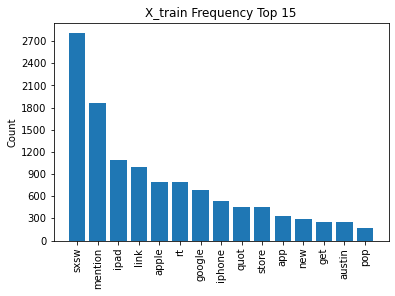

In [44]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
train_freq_dist = FreqDist(X_train['Tweet_tokens'].explode())
plot_frequency(train_freq_dist, "X_train Frequency Top 15")

In [45]:
X_train

,tweet_text,Tweet_tokens
3944,give away ipad x box book mention sxsw techenvy,"[give, away, ipad, x, box, book, mention, sxsw..."
7306,set ipad swift upbeat service morning sxsw app...,"[set, ipad, swift, upbeat, service, morning, s..."
2730,third time charm gt gt gt google launch new so...,"[third, time, charm, gt, gt, gt, google, launc..."
3568,mention use think start make great apps offici...,"[mention, use, think, start, make, great, apps..."
1146,hopefully best thing come sxsw fact people fly...,"[hopefully, best, thing, come, sxsw, fact, peo..."
...,...,...
2760,dear apple could roll hot dog cart full ipad a...,"[dear, apple, could, roll, hot, dog, cart, ful..."
3151,kick sxswi mention give away ipad visit fb pag...,"[kick, sxswi, mention, give, away, ipad, visit..."
2121,mention cnngrill sxsw rockin iphone cooler link,"[mention, cnngrill, sxsw, rockin, iphone, cool..."
8989,crazy much culture document google doodle sxsw,"[crazy, much, culture, document, google, doodl..."


In [46]:
#secondary split for holdout
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          test_size=0.25, random_state=42)

In [47]:
cvec = CountVectorizer(max_features=100, stop_words=sw, strip_accents='ascii')
X_t_vec = cvec.fit_transform(X_t['tweet_text'])
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cvec.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,amp,android,app,apple,apps,around,austin,awesome,begin,best,...,user,via,video,wait,want,well,win,work,would,year
7411,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5059,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
6344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6746,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7233,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
X_val_vec = cvec.transform(X_val['tweet_text'])
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cvec.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)
X_val_vec

,amp,android,app,apple,apps,around,austin,awesome,begin,best,...,user,via,video,wait,want,well,win,work,would,year
2932,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5305,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3129,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3934,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1778,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1676,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Multinomial Bayes Models

In [49]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [50]:
mnb.n_features_

100

In [51]:
#prior probabilities by label
prior_1 = y_t.value_counts()[1]/len(y_t)
prior_0 = y_t.value_counts()[0]/len(y_t)
print(prior_0, prior_1)

0.1568922305764411 0.8431077694235589


In [52]:
mnb.class_log_prior_

array([-1.85219614, -0.17066049])

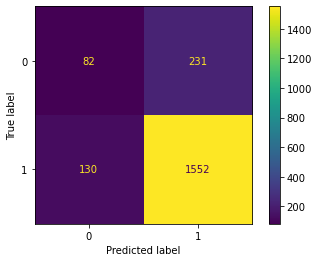

In [53]:
from sklearn.metrics import accuracy_score, precision_score, plot_confusion_matrix
plot_confusion_matrix(mnb, X_t_vec, y_t);

In [54]:
mnb.score(X_t_vec, y_t)

0.819047619047619

In [55]:
mnb.score(X_val_vec, y_val)

0.7867867867867868

In [56]:
tfidf = TfidfVectorizer(stop_words=sw, lowercase=True, token_pattern=r"([a-zA-Z]+)", strip_accents='ascii')

X_t_tf = tfidf.fit_transform(X_t['tweet_text'])
X_t_tf  = pd.DataFrame.sparse.from_spmatrix(X_t_tf)
X_t_tf.columns = sorted(tfidf.vocabulary_)
X_t_tf.set_index(y_t.index, inplace=True)
X_t_tf

,aapl,abacus,abandon,aber,able,abroad,absolutely,abt,abuzz,academy,...,zazzlsxsw,zero,zimride,zing,zite,zms,zombie,zomg,zoom,zzzs
7411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
X_val_tf = tfidf.transform(X_val['tweet_text'])
X_val_tf  = pd.DataFrame.sparse.from_spmatrix(X_val_tf)
X_val_tf.columns = sorted(tfidf.vocabulary_)
X_val_tf.set_index(y_val.index, inplace=True)
X_val_tf

,aapl,abacus,abandon,aber,able,abroad,absolutely,abt,abuzz,academy,...,zazzlsxsw,zero,zimride,zing,zite,zms,zombie,zomg,zoom,zzzs
2932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
mnb2 = MultinomialNB()

mnb2.fit(X_t_tf, y_t)

MultinomialNB()

0.8556390977443609


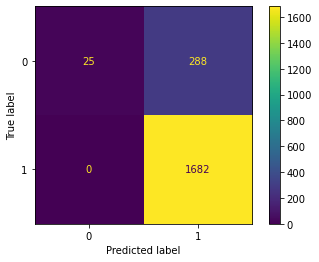

In [59]:
plot_confusion_matrix(mnb2,X_t_tf, y_t);
print(mnb2.score(X_t_tf, y_t))

In [60]:
mnb2.score(X_val_tf, y_val)

0.8243243243243243

### Random Forest Models

In [61]:
rf = RandomForestClassifier()
rf.fit(X_t_tf, y_t)

RandomForestClassifier()

In [62]:
rf.score(X_t_tf, y_t)

1.0

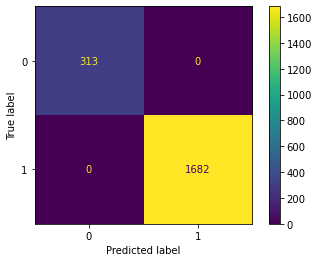

In [63]:
plot_confusion_matrix(rf,X_t_tf, y_t);

In [64]:
rf.score(X_val_tf, y_val)

0.8498498498498499

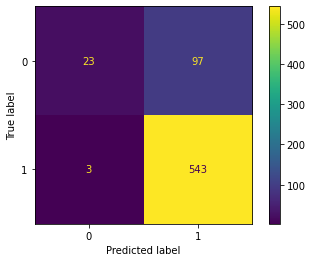

In [65]:
plot_confusion_matrix(rf,X_val_tf, y_val);

In [160]:
from sklearn.model_selection import GridSearchCV

In [161]:
# rf_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [1, 2, 3, 5],
#     'min_samples_leaf' : [1, 5, 10, 25]
# }

# rf_gs = GridSearchCV(rf, rf_grid, cv=5)

In [162]:
# rf_gs.fit(X_t_tf, y_t)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 5],
                         'min_samples_leaf': [1, 5, 10, 25]})

In [163]:
# rf_gs.best_params_

{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}

In [164]:
# rf_gs.best_score_

0.8431077694235588